# 초기 세팅

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [3]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [4]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [6]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [7]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [8]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [9]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

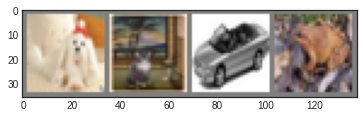

dog	 cat	 car	 frog	


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

In [11]:
images.shape

torch.Size([4, 3, 32, 32])

# 모델 1

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [18]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(10, 15, 3, 1, 1)
      self.conv3 = nn.Conv2d(15, 25, 4, 2)
      self.fc1 = nn.Linear(225, 50)
      self.fc2 = nn.Linear(50, 10)
      
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, (2,))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x

    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [19]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(15, 25, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=225, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [12]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [21]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [22]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 10, 32, 32]             280
            Conv2d-2            [4, 15, 16, 16]           1,365
            Conv2d-3              [4, 25, 7, 7]           6,025
            Linear-4                    [4, 50]          11,300
            Linear-5                    [4, 10]             510
Total params: 19,480
Trainable params: 19,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.47
Params size (MB): 0.07
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [24]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [25]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # 가중치 초기화

        y_pred = myNet(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.2178036366701126
Epoch: 1, Batch: 4000, Loss: 1.9459464305341243
Epoch: 1, Batch: 6000, Loss: 1.7487425505518914
Epoch: 1, Batch: 8000, Loss: 1.6151623934209347
Epoch: 1, Batch: 10000, Loss: 1.5382168479412794
Epoch: 1, Batch: 12000, Loss: 1.4950300815328956
Epoch: 2, Batch: 2000, Loss: 1.416332402601838
Epoch: 2, Batch: 4000, Loss: 1.3548152931034565
Epoch: 2, Batch: 6000, Loss: 1.3213663119152188
Epoch: 2, Batch: 8000, Loss: 1.2907258255034686
Epoch: 2, Batch: 10000, Loss: 1.2684827827848495
Epoch: 2, Batch: 12000, Loss: 1.2461101721227168
Epoch: 3, Batch: 2000, Loss: 1.1871636418374256
Epoch: 3, Batch: 4000, Loss: 1.1637929659225046
Epoch: 3, Batch: 6000, Loss: 1.1627463685795665
Epoch: 3, Batch: 8000, Loss: 1.1484552529193461
Epoch: 3, Batch: 10000, Loss: 1.1528204260207713
Epoch: 3, Batch: 12000, Loss: 1.1293118499722332
Epoch: 4, Batch: 2000, Loss: 1.0797960397545248
Epoch: 4, Batch: 4000, Loss: 1.0823639285359532
Epoch: 4, Batch: 6000, Loss: 1.0799

## 모델의 저장 및 로드

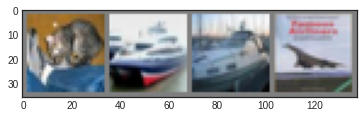

	cat 	ship 	ship 	plane


In [26]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [27]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [28]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [31]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

63.33


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [32]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 62.4%
Accuracy of car: 78.8%
Accuracy of bird: 58.3%
Accuracy of cat: 29.3%
Accuracy of deer: 53.8%
Accuracy of dog: 54.3%
Accuracy of frog: 90.7%
Accuracy of horse: 54.4%
Accuracy of ship: 80.3%
Accuracy of truck: 71.0%


# 모델2

## 모델 2 학습

In [23]:
class Net2(nn.Module):
    def __init__(self):
      super(Net2, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 64)
      self.fc2 = nn.Linear(64, 10)
      #self.bn = nn.BatchNorm2d(32)
      
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, (2,))
      #x = self.bn(x)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, (2,))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x

    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [24]:
myNet2 = Net2().to(device)

In [27]:
# output; (4 * 10)

output2 = myNet2.forward(input)
output2.size()

torch.Size([4, 10])

In [28]:
# 모델 구조 확인

summary(myNet2, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 32, 32]             448
            Conv2d-2            [4, 32, 16, 16]           4,640
            Conv2d-3              [4, 64, 8, 8]          18,496
            Linear-4                    [4, 64]          65,600
            Linear-5                    [4, 10]             650
Total params: 89,834
Trainable params: 89,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.88
Params size (MB): 0.34
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [30]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer2 = optim.SGD(myNet2.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [32]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer2.zero_grad() # 가중치 초기화

        y_pred = myNet2(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer2.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.1897042883634565
Epoch: 1, Batch: 4000, Loss: 1.8037723819315434
Epoch: 1, Batch: 6000, Loss: 1.5643979483544828
Epoch: 1, Batch: 8000, Loss: 1.446375856027007
Epoch: 1, Batch: 10000, Loss: 1.3838920777514576
Epoch: 1, Batch: 12000, Loss: 1.30367446564883
Epoch: 2, Batch: 2000, Loss: 1.2175223337337375
Epoch: 2, Batch: 4000, Loss: 1.140997240351513
Epoch: 2, Batch: 6000, Loss: 1.1114213895043359
Epoch: 2, Batch: 8000, Loss: 1.0812395253162832
Epoch: 2, Batch: 10000, Loss: 1.0540829652473331
Epoch: 2, Batch: 12000, Loss: 1.0261862080236896
Epoch: 3, Batch: 2000, Loss: 0.9276319090984761
Epoch: 3, Batch: 4000, Loss: 0.9238292898586952
Epoch: 3, Batch: 6000, Loss: 0.8933581525888294
Epoch: 3, Batch: 8000, Loss: 0.917684628913179
Epoch: 3, Batch: 10000, Loss: 0.8867296826830133
Epoch: 3, Batch: 12000, Loss: 0.8891888177022338
Epoch: 4, Batch: 2000, Loss: 0.785427140392363
Epoch: 4, Batch: 4000, Loss: 0.8135234054210596
Epoch: 4, Batch: 6000, Loss: 0.794339018

## 모델의 저장 및 로드

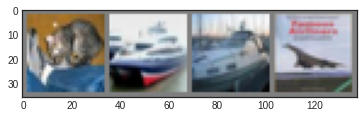

	cat 	ship 	ship 	plane


In [33]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [34]:
# 저장

PATH = './cifar_net2.pth'
torch.save(myNet2.state_dict(), PATH)

In [35]:
# 불러오기

Loaded_Net2 = Net2().to(device)
Loaded_Net2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [36]:
# 전체 accuracy 확인; 70% 이상 성능값

correct2 = 0
total2 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet2(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total2 += labels.size(0) # 전체 갯수
        correct2 += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct2 / total2)

70.76


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [37]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct2 = list(0. for i in range(10))
class_total2 = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net2(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct2[label] += c[i].item()
            class_total2[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct2[i] / class_total2[i]))

Accuracy of plane: 83.0%
Accuracy of car: 81.9%
Accuracy of bird: 54.5%
Accuracy of cat: 54.8%
Accuracy of deer: 73.0%
Accuracy of dog: 65.4%
Accuracy of frog: 67.5%
Accuracy of horse: 76.7%
Accuracy of ship: 73.3%
Accuracy of truck: 77.5%


# 모델3

In [38]:
class Net3(nn.Module):
    def __init__(self):
      super(Net3, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 64)
      self.fc2 = nn.Linear(64, 10)
      self.bn = nn.BatchNorm2d(32)
      
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, (2,))
      x = self.bn(x)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, (2,))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x

    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [39]:
myNet3 = Net3().to(device)

In [40]:
# output; (4 * 10)

output3 = myNet3.forward(input)
output3.size()

torch.Size([4, 10])

In [41]:
# 모델 구조 확인

summary(myNet3, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 32, 32]             448
            Conv2d-2            [4, 32, 16, 16]           4,640
       BatchNorm2d-3              [4, 32, 8, 8]              64
            Conv2d-4              [4, 64, 8, 8]          18,496
            Linear-5                    [4, 64]          65,600
            Linear-6                    [4, 10]             650
Total params: 89,898
Trainable params: 89,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.94
Params size (MB): 0.34
Estimated Total Size (MB): 1.33
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [42]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer3 = optim.SGD(myNet3.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [43]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer3.zero_grad() # 가중치 초기화

        y_pred = myNet3(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer3.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.7408435100317001
Epoch: 1, Batch: 4000, Loss: 1.4576258484423161
Epoch: 1, Batch: 6000, Loss: 1.3150781997516752
Epoch: 1, Batch: 8000, Loss: 1.2055950712636112
Epoch: 1, Batch: 10000, Loss: 1.135157524369657
Epoch: 1, Batch: 12000, Loss: 1.0799253433505074
Epoch: 2, Batch: 2000, Loss: 1.0074747532699257
Epoch: 2, Batch: 4000, Loss: 0.9633566287141293
Epoch: 2, Batch: 6000, Loss: 0.9354793101260439
Epoch: 2, Batch: 8000, Loss: 0.9296738360049203
Epoch: 2, Batch: 10000, Loss: 0.9304865392986685
Epoch: 2, Batch: 12000, Loss: 0.8752222172878683
Epoch: 3, Batch: 2000, Loss: 0.7957357744970359
Epoch: 3, Batch: 4000, Loss: 0.803426974425558
Epoch: 3, Batch: 6000, Loss: 0.8048674562498928
Epoch: 3, Batch: 8000, Loss: 0.7873959144006949
Epoch: 3, Batch: 10000, Loss: 0.793718789939885
Epoch: 3, Batch: 12000, Loss: 0.7896431087104138
Epoch: 4, Batch: 2000, Loss: 0.6940915743662044
Epoch: 4, Batch: 4000, Loss: 0.7219570997008122
Epoch: 4, Batch: 6000, Loss: 0.707017

## 모델의 저장 및 로드

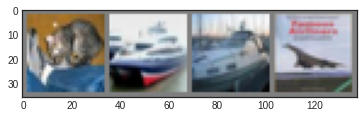

	cat 	ship 	ship 	plane


In [44]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [45]:
# 저장

PATH = './cifar_net3.pth'
torch.save(myNet3.state_dict(), PATH)

In [46]:
# 불러오기

Loaded_Net3 = Net3().to(device)
Loaded_Net3.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [47]:
# 전체 accuracy 확인; 70% 이상 성능값

correct3 = 0
total3 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet3(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total3 += labels.size(0) # 전체 갯수
        correct3 += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct3 / total3)

73.12


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [48]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct3 = list(0. for i in range(10))
class_total3 = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net3(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct3[label] += c[i].item()
            class_total3[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct3[i] / class_total3[i]))

Accuracy of plane: 78.2%
Accuracy of car: 79.7%
Accuracy of bird: 55.7%
Accuracy of cat: 56.8%
Accuracy of deer: 63.7%
Accuracy of dog: 63.6%
Accuracy of frog: 84.8%
Accuracy of horse: 81.8%
Accuracy of ship: 82.8%
Accuracy of truck: 84.1%


# 모델 4

In [50]:
class Net4(nn.Module):
    def __init__(self):
      super(Net4, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 64)
      self.fc2 = nn.Linear(64, 10)
      self.bn1 = nn.BatchNorm2d(16)
      self.bn2 = nn.BatchNorm2d(32)
      self.bn3 = nn.BatchNorm2d(64)
      
    def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.bn3(self.conv3(x)))
      x = F.max_pool2d(x, (2,))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x

    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [51]:
myNet4 = Net4().to(device)

In [52]:
# output; (4 * 10)

output4 = myNet4.forward(input)
output4.size()

torch.Size([4, 10])

In [53]:
# 모델 구조 확인

summary(myNet4, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 32, 32]             448
       BatchNorm2d-2            [4, 16, 32, 32]              32
            Conv2d-3            [4, 32, 16, 16]           4,640
       BatchNorm2d-4            [4, 32, 16, 16]              64
            Conv2d-5              [4, 64, 8, 8]          18,496
       BatchNorm2d-6              [4, 64, 8, 8]             128
            Linear-7                    [4, 64]          65,600
            Linear-8                    [4, 10]             650
Total params: 90,058
Trainable params: 90,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.75
Params size (MB): 0.34
Estimated Total Size (MB): 2.14
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [54]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer4 = optim.SGD(myNet4.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [55]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer4.zero_grad() # 가중치 초기화

        y_pred = myNet4(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer4.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.7479746716320514
Epoch: 1, Batch: 4000, Loss: 1.465475874260068
Epoch: 1, Batch: 6000, Loss: 1.335789485629648
Epoch: 1, Batch: 8000, Loss: 1.2596652325876057
Epoch: 1, Batch: 10000, Loss: 1.206718226786703
Epoch: 1, Batch: 12000, Loss: 1.1617772353552283
Epoch: 2, Batch: 2000, Loss: 1.0564573279060423
Epoch: 2, Batch: 4000, Loss: 1.034114745080471
Epoch: 2, Batch: 6000, Loss: 1.0086439634840936
Epoch: 2, Batch: 8000, Loss: 0.9899886647481472
Epoch: 2, Batch: 10000, Loss: 0.9643627135134302
Epoch: 2, Batch: 12000, Loss: 0.9487046124190092
Epoch: 3, Batch: 2000, Loss: 0.8729316776283086
Epoch: 3, Batch: 4000, Loss: 0.8470482930620201
Epoch: 3, Batch: 6000, Loss: 0.8516113296002149
Epoch: 3, Batch: 8000, Loss: 0.8596101244129241
Epoch: 3, Batch: 10000, Loss: 0.8555275909183547
Epoch: 3, Batch: 12000, Loss: 0.8168838971741498
Epoch: 4, Batch: 2000, Loss: 0.7638430837122724
Epoch: 4, Batch: 4000, Loss: 0.776288016019389
Epoch: 4, Batch: 6000, Loss: 0.74801326

## 모델의 저장 및 로드

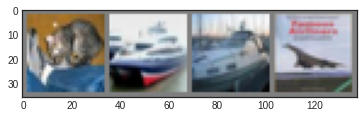

	cat 	ship 	ship 	plane


In [56]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [57]:
# 저장

PATH = './cifar_net4.pth'
torch.save(myNet4.state_dict(), PATH)

In [58]:
# 불러오기

Loaded_Net4 = Net4().to(device)
Loaded_Net4.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [59]:
# 전체 accuracy 확인; 70% 이상 성능값

correct4 = 0
total4 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet4(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total4 += labels.size(0) # 전체 갯수
        correct4 += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct4 / total4)

74.28


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [60]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct4 = list(0. for i in range(10))
class_total4 = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net4(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct4[label] += c[i].item()
            class_total4[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct4[i] / class_total4[i]))

Accuracy of plane: 82.6%
Accuracy of car: 80.3%
Accuracy of bird: 66.9%
Accuracy of cat: 55.3%
Accuracy of deer: 72.6%
Accuracy of dog: 59.0%
Accuracy of frog: 83.5%
Accuracy of horse: 76.2%
Accuracy of ship: 80.6%
Accuracy of truck: 85.8%


# 모델 5

In [13]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        ), nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        ), nn.Sequential( 
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), 
            nn.Flatten(), 
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.classifier(x)
        
        return x


In [14]:
myNet5 = Net5().to(device)

In [15]:
# output; (4 * 10)

output5 = myNet5.forward(input)
output5.size()

torch.Size([4, 10])

In [16]:
# 모델 구조 확인

summary(myNet5, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
              ReLU-3            [4, 64, 32, 32]               0
            Conv2d-4           [4, 128, 32, 32]          73,856
       BatchNorm2d-5           [4, 128, 32, 32]             256
              ReLU-6           [4, 128, 32, 32]               0
         MaxPool2d-7           [4, 128, 16, 16]               0
            Conv2d-8           [4, 128, 16, 16]         147,584
       BatchNorm2d-9           [4, 128, 16, 16]             256
             ReLU-10           [4, 128, 16, 16]               0
           Conv2d-11           [4, 128, 16, 16]         147,584
      BatchNorm2d-12           [4, 128, 16, 16]             256
             ReLU-13           [4, 128, 16, 16]               0
           Conv2d-14           [4, 256,

## 손실함수와 옵티마이저

In [17]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer5 = optim.SGD(myNet5.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [18]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer5.zero_grad() # 가중치 초기화

        y_pred = myNet5(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer5.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 3.0272886006236077
Epoch: 1, Batch: 4000, Loss: 2.17025870475173
Epoch: 1, Batch: 6000, Loss: 1.8783464467525481
Epoch: 1, Batch: 8000, Loss: 1.7373099431991577
Epoch: 1, Batch: 10000, Loss: 1.4945757301449776
Epoch: 1, Batch: 12000, Loss: 1.413615225320682
Epoch: 2, Batch: 2000, Loss: 1.2645893925614655
Epoch: 2, Batch: 4000, Loss: 1.1352671270160937
Epoch: 2, Batch: 6000, Loss: 1.1113466105340049
Epoch: 2, Batch: 8000, Loss: 1.0485606567190262
Epoch: 2, Batch: 10000, Loss: 0.9661415883100126
Epoch: 2, Batch: 12000, Loss: 0.9171073239769321
Epoch: 3, Batch: 2000, Loss: 0.8192387740346603
Epoch: 3, Batch: 4000, Loss: 0.7973134603383951
Epoch: 3, Batch: 6000, Loss: 0.774509567984147
Epoch: 3, Batch: 8000, Loss: 0.7525029705832712
Epoch: 3, Batch: 10000, Loss: 0.7334242596122204
Epoch: 3, Batch: 12000, Loss: 0.7196772519788356
Epoch: 4, Batch: 2000, Loss: 0.6103413684619009
Epoch: 4, Batch: 4000, Loss: 0.6125630740846973
Epoch: 4, Batch: 6000, Loss: 0.5954909

## 모델의 저장 및 로드

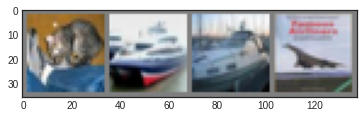

	cat 	ship 	ship 	plane


In [19]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [20]:
# 저장

PATH = './cifar_net5.pth'
torch.save(myNet5.state_dict(), PATH)

In [21]:
# 불러오기

Loaded_Net5 = Net5().to(device)
Loaded_Net5.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [22]:
# 전체 accuracy 확인; 70% 이상 성능값

correct5 = 0
total5 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet5(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total5 += labels.size(0) # 전체 갯수
        correct5 += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct5 / total5)

83.98


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [23]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct5 = list(0. for i in range(10))
class_total5 = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net5(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct5[label] += c[i].item()
            class_total5[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct5[i] / class_total5[i]))

Accuracy of plane: 90.0%
Accuracy of car: 95.9%
Accuracy of bird: 62.0%
Accuracy of cat: 64.5%
Accuracy of deer: 90.6%
Accuracy of dog: 84.7%
Accuracy of frog: 84.4%
Accuracy of horse: 86.7%
Accuracy of ship: 94.0%
Accuracy of truck: 87.0%


# 모델 6

In [27]:
class Net6(nn.Module):
    def __init__(self):
      super(Net6, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*128, 64)
      self.fc2 = nn.Linear(64, 10)
      self.bn1 = nn.BatchNorm2d(32)
      self.bn2 = nn.BatchNorm2d(64)
      self.bn3 = nn.BatchNorm2d(128)
      
    def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(x, (2,))
      x = F.relu(self.bn3(self.conv3(x)))
      x = F.max_pool2d(x, (2,))
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      return x

    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [28]:
myNet6 = Net6().to(device)

In [29]:
# output; (4 * 10)

output6 = myNet6.forward(input)
output6.size()

torch.Size([4, 10])

In [30]:
# 모델 구조 확인

summary(myNet6, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 32, 32, 32]             896
       BatchNorm2d-2            [4, 32, 32, 32]              64
            Conv2d-3            [4, 64, 16, 16]          18,496
       BatchNorm2d-4            [4, 64, 16, 16]             128
            Conv2d-5             [4, 128, 8, 8]          73,856
       BatchNorm2d-6             [4, 128, 8, 8]             256
            Linear-7                    [4, 64]         131,136
            Linear-8                    [4, 10]             650
Total params: 225,482
Trainable params: 225,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.50
Params size (MB): 0.86
Estimated Total Size (MB): 4.41
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [31]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer6 = optim.SGD(myNet6.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [32]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer6.zero_grad() # 가중치 초기화

        y_pred = myNet6(inputs) # y_pred
        loss = criterion(y_pred, labels) # 손실함수를 이용해서 loss계산
        loss.backward()  # back-propagation
        optimizer6.step() # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.7602602669894696
Epoch: 1, Batch: 4000, Loss: 1.4849180883094668
Epoch: 1, Batch: 6000, Loss: 1.340417662192136
Epoch: 1, Batch: 8000, Loss: 1.257006684165448
Epoch: 1, Batch: 10000, Loss: 1.1665583917042242
Epoch: 1, Batch: 12000, Loss: 1.1570333035159857
Epoch: 2, Batch: 2000, Loss: 1.0394397596502676
Epoch: 2, Batch: 4000, Loss: 1.0065120179909282
Epoch: 2, Batch: 6000, Loss: 0.9904655431248247
Epoch: 2, Batch: 8000, Loss: 0.9643602638039738
Epoch: 2, Batch: 10000, Loss: 0.9473488567089662
Epoch: 2, Batch: 12000, Loss: 0.9183133560842834
Epoch: 3, Batch: 2000, Loss: 0.8355370455747471
Epoch: 3, Batch: 4000, Loss: 0.821678781434428
Epoch: 3, Batch: 6000, Loss: 0.8026625525737181
Epoch: 3, Batch: 8000, Loss: 0.8372161676059477
Epoch: 3, Batch: 10000, Loss: 0.8046403253431781
Epoch: 3, Batch: 12000, Loss: 0.7832090417956933
Epoch: 4, Batch: 2000, Loss: 0.691767124793725
Epoch: 4, Batch: 4000, Loss: 0.69686898884119
Epoch: 4, Batch: 6000, Loss: 0.711921971

## 모델의 저장 및 로드

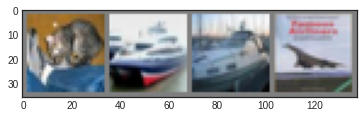

	cat 	ship 	ship 	plane


In [33]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [34]:
# 저장

PATH = './cifar_net6.pth'
torch.save(myNet6.state_dict(), PATH)

In [35]:
# 불러오기

Loaded_Net6 = Net6().to(device)
Loaded_Net6.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [36]:
# 전체 accuracy 확인; 70% 이상 성능값

correct6 = 0
total6 = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        y_pred = myNet6(images)                                             # y_pred
        _, predicted = torch.max(y_pred.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total6 += labels.size(0) # 전체 갯수
        correct6 += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct6 / total6)

75.72


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [37]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct6 = list(0. for i in range(10))
class_total6 = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net6(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct6[label] += c[i].item()
            class_total6[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct6[i] / class_total6[i]))

Accuracy of plane: 77.5%
Accuracy of car: 78.3%
Accuracy of bird: 64.9%
Accuracy of cat: 48.3%
Accuracy of deer: 73.9%
Accuracy of dog: 69.8%
Accuracy of frog: 82.9%
Accuracy of horse: 84.4%
Accuracy of ship: 87.7%
Accuracy of truck: 89.5%
